<a href="https://colab.research.google.com/github/EmilyCosta/ROS_Intro/blob/master/Determina%C3%A7%C3%A3o_das_Fun%C3%A7%C3%B5es_de_Transferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Definições Iniciais do Colab

In [ ]:
#Montar o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Instalações Necessárias
!pip install slycot 
!pip install control

     |████████████████████████████████| 1.5 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417931 sha256=7eb772ff7211ce243a1db1b0836784944af52e05cb8f857798fcf35e78cd3a73
  Stored in directory: /root/.cache/pip/wheels/fa/b2/19/1e6568896fbabaf2a03d2fb6575211d281afcb9e00ce026cf6
Successfully built slycot
     |████████████████████████████████| 339 kB 4.3 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=b2bf0d5708b4e040108f5980a05f90e5c57d264cb44d1b171988eb31162a1fa4
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd     
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt 
from scipy import optimize as opt
import seaborn as sns
from control.matlab import *
import sympy

#Funções de Transferência

Inicialmente é necessário realizar uma coleta dos dados gerados pelos encoders dos motores para ser possivel levantar a função de transferencia deles.
Nesse caso foi utilizado um robô omnidirecional com três motores

##Dados

Para que seja possivel cobrir um maior espectro do comportamento dos motores e assim dimensionar uma função de transferência mais ajustada foram coletados dados de tempo e posição dos motores em 3 configurações diferentes e com duas entradas diferentes uma entrada 200 pwm e uma de -200 pwm.

Os dados coletados foram salvos em um arquivo txt e foram inportados em DataFrames


In [ ]:
# Leitura dos arquivos de dados
DF1 = pd.read_csv('/content/drive/MyDrive/Motores Robô Omni/dataM1M2.txt', sep=";",header=None) #arquivo que será lido
DF1.columns = ["i","Motor1","Motor2","Motor3","Time"] #nomeando as colunas
DF2 = pd.read_csv('/content/drive/MyDrive/Motores Robô Omni/dataM1M3.txt', sep=";",header=None)
DF2.columns = ["i","Motor1","Motor2","Motor3","Time"]
DF3 = pd.read_csv('/content/drive/MyDrive/Motores Robô Omni/dataM2M3.txt', sep=";",header=None)
DF3.columns = ["i","Motor1","Motor2","Motor3","Time"]

Nas colunas **Motor 1**, **Motor 2** e **Motor 3** são apresentados os dados coletados dos pulsos dados nos encoderes em cada uma das coletas. À partir desses arquivos, forma criados Data Frames com índice, leituras de cada motor e o tempo. 


In [ ]:
print(DF1.head())

     i  Motor1  Motor2  Motor3  Time
0  000    26.0   -50.0     0.0  11.0
1  001    80.0  -114.0     0.0  22.0
2  002   150.0  -180.0     0.0  33.0
3  003   213.0  -235.0     0.0  44.0
4  004   285.0  -296.0     0.0  55.0


 Em cada um deles, foram retiradas as linhas com valores zero e a última linha, a qual possuía apenas o caractere de parada (#) inserido pelo programa do arduino. Além disso, foi inserida uma linha apenas com zeros no final da lista e, com a reorganização dos índices, tornou-se a primeira para possibilitar o cálculo das velocidade utilizando uma regressão de dois pontos.

In [ ]:
#Formatação DataFrames
DF1 = DF1.query('Motor1 != 0 and i != "#"') #retira a última linha (contém apenas um '#') e a linha do meio, a qual possui apenas valores nulos (inversão de sentido do robô)
DF1 = DF1.drop(labels='i',axis=1) #exclui a primeira coluna (contagem de dados), utilizaremos o índice dado pelo data frame
DF1.loc[-1] = [0,0,0,0] #insere uma linha só com valores nulos no final do data frame
DF1.index = DF1.index + 1 #para trocar o índice -1 da linha adicionada para zero e manter a sequência numérica
DF1 = DF1.sort_index() #organiza os índices em ordem numérica (progressiva)
DF1.index = range(0,len(DF1)) #renumera os índices (compensa a retirada do índice 200 e inserção da linha nula)
DF1['Time'] = DF1['Time']/1000

DF2 = DF2.query('Motor1 != 0 and i != "#"')
DF2 = DF2.drop(labels='i',axis=1)
DF2.loc[-1] = [0,0,0,0] 
DF2.index = DF2.index + 1
DF2 = DF2.sort_index() 
DF2.index = range(0,len(DF2))
DF2['Time'] = DF2['Time']/1000

DF3 = DF3.query('Motor3 != 0 and i != "#"') #Motor1 não pode ser usado como parâmetro, pois ele não foi lido nesse conjunto de dados
DF3 = DF3.drop(labels='i',axis=1)
DF3.loc[-1] = [0,0,0,0] 
DF3.index = DF3.index + 1
DF3 = DF3.sort_index() 
DF3.index = range(0,len(DF3))
DF3['Time'] = DF3['Time']/1000


In [ ]:
DF1

,Motor1,Motor2,Motor3,Time
0,0.0,0.0,0.0,0.000
1,26.0,-50.0,0.0,0.011
2,80.0,-114.0,0.0,0.022
3,150.0,-180.0,0.0,0.033
4,213.0,-235.0,0.0,0.044
...,...,...,...,...
394,4332.0,-4624.0,-17.0,4.347
395,4149.0,-4442.0,-17.0,4.358
396,3949.0,-4243.0,-17.0,4.369
397,3751.0,-4042.0,-17.0,4.380


Após formatação dos DataFrames, foi necessário o calculo da velocidade de cada um dos motores, já que iremos fazer o controle da velocidade.  O cálculo da velocidade de cada instante deu-se através da subtração do valor do motor atual pelo anterior dividido pelo tempo, o qual foi calculado através do mesmo método (v = [Mi - M(i-1)] / [ti - t(i-1)])


In [ ]:
#Calculo da velociade em rot/s
for i in DF1.index:
  if i != 0:
    DF1.loc[i,"Vel1"] = ((DF1.loc[i,"Motor1"] - DF1.loc[i-1,"Motor1"])/5280)/ (DF1.loc[i,"Time"] - DF1.loc[i-1,"Time"]) #v = Delta p/ Delta t
    DF1.loc[i,"Vel2"] = ((DF1.loc[i,"Motor2"] - DF1.loc[i-1,"Motor2"])/5280)/ (DF1.loc[i,"Time"] - DF1.loc[i-1,"Time"])
    DF1.loc[i,"Vel3"] = ((DF1.loc[i,"Motor3"] - DF1.loc[i-1,"Motor3"])/5280)/ (DF1.loc[i,"Time"] - DF1.loc[i-1,"Time"])
  else:
    DF1.loc[i,"Vel1"] = 0 #primeiras linhas não têm linhas anteriores para calcular a velocidade
    DF1.loc[i,"Vel2"] = 0
    DF1.loc[i,"Vel3"] = 0

for i in DF2.index:
  if i != 0:
    DF2.loc[i,"Vel1"] = ((DF2.loc[i,"Motor1"] - DF2.loc[i-1,"Motor1"])/5280)/ (DF2.loc[i,"Time"] - DF2.loc[i-1,"Time"])
    DF2.loc[i,"Vel2"] = ((DF2.loc[i,"Motor2"] - DF2.loc[i-1,"Motor2"])/5280)/ (DF2.loc[i,"Time"] - DF2.loc[i-1,"Time"])
    DF2.loc[i,"Vel3"] = ((DF2.loc[i,"Motor3"] - DF2.loc[i-1,"Motor3"])/5280)/ (DF2.loc[i,"Time"] - DF2.loc[i-1,"Time"])
  else:
    DF2.loc[i,"Vel1"] = 0
    DF2.loc[i,"Vel2"] = 0
    DF2.loc[i,"Vel3"] = 0

for i in DF3.index:
  if i != 0:
    DF3.loc[i,"Vel1"] = ((DF3.loc[i,"Motor1"] - DF3.loc[i-1,"Motor1"])/5280)/ (DF3.loc[i,"Time"] - DF3.loc[i-1,"Time"])
    DF3.loc[i,"Vel2"] = ((DF3.loc[i,"Motor2"] - DF3.loc[i-1,"Motor2"])/5280)/ (DF3.loc[i,"Time"] - DF3.loc[i-1,"Time"])
    DF3.loc[i,"Vel3"] = ((DF3.loc[i,"Motor3"] - DF3.loc[i-1,"Motor3"])/5280)/ (DF3.loc[i,"Time"] - DF3.loc[i-1,"Time"])
  else:
    DF3.loc[i,"Vel1"] = 0
    DF3.loc[i,"Vel2"] = 0
    DF3.loc[i,"Vel3"] = 0

In [ ]:
DF1

,Motor1,Motor2,Motor3,Time,Vel1,Vel2,Vel3
0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.0
1,26.0,-50.0,0.0,0.011,0.447658,-0.860882,0.0
2,80.0,-114.0,0.0,0.022,0.929752,-1.101928,0.0
3,150.0,-180.0,0.0,0.033,1.205234,-1.136364,0.0
4,213.0,-235.0,0.0,0.044,1.084711,-0.946970,0.0
...,...,...,...,...,...,...,...
394,4332.0,-4624.0,-17.0,4.347,-3.357438,3.374656,0.0
395,4149.0,-4442.0,-17.0,4.358,-3.150826,3.133609,0.0
396,3949.0,-4243.0,-17.0,4.369,-3.443526,3.426309,0.0
397,3751.0,-4042.0,-17.0,4.380,-3.409091,3.460744,0.0


In [ ]:
#Acrescimo das entradas (3 novas colunas em cada DF)
for i in range(0,200):
  DF1.loc[i,"U1"] = 200
  DF1.loc[i,"U2"] = -200
  DF1.loc[i,"U3"] = 0

  DF2.loc[i,"U1"] = 200
  DF2.loc[i,"U2"] = 0
  DF2.loc[i,"U3"] = -200

  DF3.loc[i,"U1"] = 0
  DF3.loc[i,"U2"] = -200
  DF3.loc[i,"U3"] = 200


for i in range(200,399):
  DF1.loc[i,"U1"] = -200
  DF1.loc[i,"U2"] = 200
  DF1.loc[i,"U3"] = 0

  DF2.loc[i,"U1"] = -200
  DF2.loc[i,"U2"] = 0
  DF2.loc[i,"U3"] = 200

  DF3.loc[i,"U1"] = 0
  DF3.loc[i,"U2"] = 200
  DF3.loc[i,"U3"] = -200

O próximo passo foi inserir mais três colunas, cada uma com os valores das respectivas entradas para cada motor em cada um dos três Data Frames (200, -200 ou 0). Em seguida, foram plotadas as velocidades em função do tempo para cada motor.

In [ ]:
DF3

,Motor1,Motor2,Motor3,Time,Vel1,Vel2,Vel3,U1,U2,U3
0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,-200.0,200.0
1,0.0,-52.0,45.0,0.011,0.0,-0.895317,0.774793,0.0,-200.0,200.0
2,0.0,-120.0,95.0,0.022,0.0,-1.170799,0.860882,0.0,-200.0,200.0
3,0.0,-188.0,148.0,0.033,0.0,-1.170799,0.912534,0.0,-200.0,200.0
4,0.0,-250.0,197.0,0.044,0.0,-1.067493,0.843664,0.0,-200.0,200.0
...,...,...,...,...,...,...,...,...,...,...
394,64.0,-6223.0,3832.0,4.347,0.0,3.495179,-3.340220,0.0,200.0,-200.0
395,64.0,-6040.0,3658.0,4.358,0.0,3.150826,-2.995868,0.0,200.0,-200.0
396,64.0,-5844.0,3464.0,4.369,0.0,3.374656,-3.340220,0.0,200.0,-200.0
397,64.0,-5641.0,3272.0,4.380,0.0,3.495179,-3.305785,0.0,200.0,-200.0


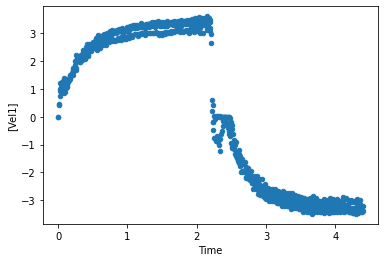

In [ ]:
#Dados de velocidade x tempo
DF1.append(DF2,ignore_index=True).plot.scatter(x="Time", y=["Vel1"])

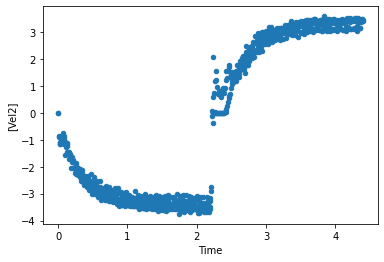

In [ ]:
#Dados de velocidade x tempo
DF1.append(DF3,ignore_index=True).plot.scatter(x="Time", y=["Vel2"])

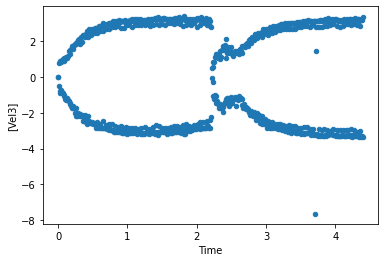

In [ ]:
#Dados de velocidade x tempo

DF2.append(DF3,ignore_index=True).plot.scatter(x="Time", y=["Vel3"])

##Definição da FT de dois métodos


Antes de iniciarmos o processo de determinação das funções de transferência, definimos as variáveis que seriam utilizadas para cada motor.

###Primeiro Método

O método 1 utiliza funções prontas e importadas de artigos sobre o levantamento de funções de transferência através de código em python. A vantagem desse método é ser possível utilizar todos os valores de velocidade de cada motor (tanto os positivos, quanto os negativos)

In [ ]:
#Método 1

#Variaveis para Motor 1
t1_m1 = np.array(DF1['Time'])
u1_m1 = np.array(DF1['U1'])
y1_m1 = np.array(DF1['Vel1'])

#Variáveis para o Motor 2
t2_m1 = np.array(DF3['Time'])
u2_m1 = np.array(DF3['U2'])
y2_m1 = np.array(DF3['Vel2'])

#Variáveis para o Motor 3
t3_m1 = np.array(DF2['Time'])
u3_m1 = np.array(DF2['U3'])
y3_m1 = np.array(DF2['Vel3'])

In [ ]:
#Definição das funções que serão utilizadas
class TF_identificator:
    def __init__(self):
        self.tf = None
        self.inputs = None

    def first_order_mdl(self, t, k, pole):
        self.tf = sig.TransferFunction(k, [pole,1])
        to, yo, xo = sig.lsim2(self.tf, U=self.inputs, T=t) #simulação da FT
        return yo


    def identify_first_order(self, t, u, orig_output, method='lm'):
        self.inputs = u
        params, params_cov = opt.curve_fit(self.first_order_mdl, t, orig_output,
                                           method=method, maxfev=1000)
        return params



In [ ]:
#Identificação das funções de cada motor
tf1_m1 = TF_identificator()
params1 = tf1_m1.identify_first_order(t1_m1, u1_m1, y1_m1)
G1 = tf(params1[0],[params1[1],1])
print(G1)

tf2_m1 = TF_identificator()
params2 = tf2_m1.identify_first_order(t2_m1, u2_m1, y2_m1)
G2 = tf(params2[0],[params2[1],1])
print(G2)

tf3_m1 = TF_identificator()
params3 = tf3_m1.identify_first_order(t3_m1, u3_m1, y3_m1)
G3 = tf(params3[0],[params3[1],1])
print(G3)



  0.01924
------------
0.7075 s + 1


  0.01596
------------
0.2199 s + 1


  0.01609
------------
0.4748 s + 1



###Segundo Método

Já no método 2, foram criadas funções autorais derivadas da teoria que embasa o estudo de funções de transferência. Sendo assim, foi possível atingir um resultado muito satisfatório quando comparado ao resultado que seria obtido através do MatLab e de forma muito mais simples.

In [ ]:
#Método 2 

#Variaveis para Motor 1
t1_m2 = np.array(DF1.append(DF2,ignore_index=True)['Time'])
y1_m2 = np.array(DF1.append(DF2,ignore_index=True)['Vel1'])
u1_m2 = np.array(DF1.append(DF2,ignore_index=True)['U1'])

#Variáveis para o Motor 2
t2_m2 = np.array(DF1.append(DF3,ignore_index=True)['Time'])
y2_m2 = np.array(DF1.append(DF3,ignore_index=True)['Vel2'])
u2_m2 = np.array(DF1.append(DF3,ignore_index=True)['U2'])

#Variáveis para o Motor 3
t3_m2 = np.array(DF2.append(DF3,ignore_index=True)['Time'])
y3_m2 = np.array(DF2.append(DF3,ignore_index=True)['Vel3'])
u3_m2 = np.array(DF2.append(DF3,ignore_index=True)['U3'])

In [ ]:
#Definição das funções autorais
class TF:
    def __init__(self):
        self.tf = None
        self.inputs = None

    def function(self, t, k, T):
        return (k*self.inputs*(1-np.exp(-t/T)))


    def identify(self, t, u, orig_output):
        self.inputs = u
        params, params_cov = opt.curve_fit(self.function, t, orig_output)
        self.tf = tf(params[0],[params[1],1.])

In [ ]:
#Determinando os parâmetros 'k' e 'tau'

tf1_m2 = TF()
tf1_m2.identify(t1_m2, u1_m2, y1_m2)
print(tf1_m2.tf)

tf2_m2 = TF()
tf2_m2.identify(t2_m2, u2_m2, y2_m2)
print(tf2_m2.tf)

tf3_m2 = TF()
tf3_m2.identify(t3_m2, u3_m2, y3_m2)
print(tf3_m2.tf)




  0.01388
------------
0.1937 s + 1


   0.0145
------------
0.1803 s + 1


  0.01365
------------
0.1861 s + 1



###Funções pelo Matlab

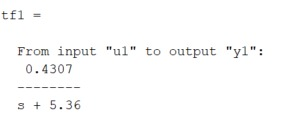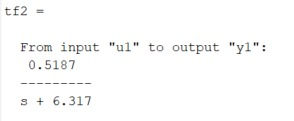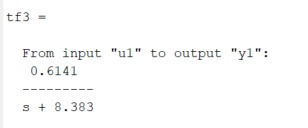

In [ ]:
tf1_ml = tf(0.08156,[1,5.36])
print(tf1_ml)
tf2_ml = tf(0.09825,[1,6.317])
print(tf2_ml)
tf3_ml = tf(0.1185,[1,8.548])
print(tf3_ml)


0.08156
--------
s + 5.36


 0.09825
---------
s + 6.317


 0.1185
---------
s + 8.548



###Comparação das funções encontradas



No final, podem-se observar as funções  de tranferência encontradas plotadas em um gráfico, para melhor visualização dos resultados.

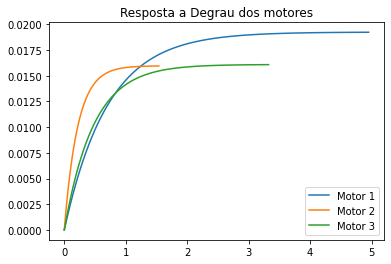

In [ ]:
#Plotando as funções encontradas Método 1
fig, ax = plt.subplots() #criação de uma figura e um axes
x1,y1 = tf1_m1.tf.step()
ax.plot(x1,y1, label='Motor 1') #plotar as coordenadas x e y e nomear esse conjunto de dados como 'Motor 1'

x2,y2 = tf2_m1.tf.step()
ax.plot(x2,y2, label='Motor 2')

x3,y3 = tf3_m1.tf.step()
ax.plot(x3,y3, label='Motor 3')

ax.set_title("Resposta a Degrau dos motores") 
ax.legend() 
plt.show()

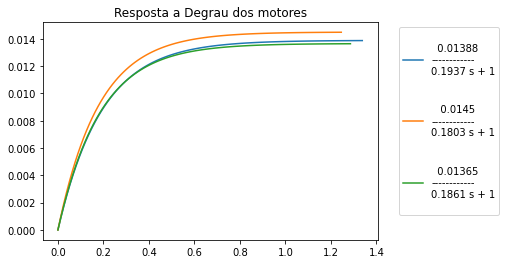

In [ ]:
#Plotando as funções encontradas Método 2
'''Funções com domínio nos complexos'''
fig, ax = plt.subplots()

y1_2,x1_2 = step(tf1_m2.tf)
ax.plot(x1_2,y1_2, label=str(tf1_m2.tf))

y2_2,x2_2 = step(tf2_m2.tf)
ax.plot(x2_2,y2_2, label=str(tf2_m2.tf))

y3_2,x3_2 = step(tf3_m2.tf)
ax.plot(x3_2,y3_2, label=str(tf3_m2.tf))

ax.set_title("Resposta a Degrau dos motores")
ax.legend()
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left' )
plt.show()

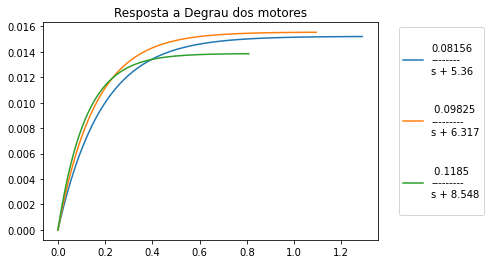

In [ ]:
#Plotando as funções encontradas MATLAB
'''Funções com domínio nos complexos'''
fig, ax = plt.subplots()
y1_3,x1_3 = step(tf1_ml)
ax.plot(x1_3,y1_3, label=(str(tf1_ml)))

y2_3,x2_3 = step(tf2_ml)
ax.plot(x2_3,y2_3, label=str(tf2_ml))

y3_3,x3_3 = step(tf3_ml)
ax.plot(x3_3,y3_3, label=str(tf3_ml))

ax.set_title("Resposta a Degrau dos motores")
ax.legend()
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left' )
plt.show()

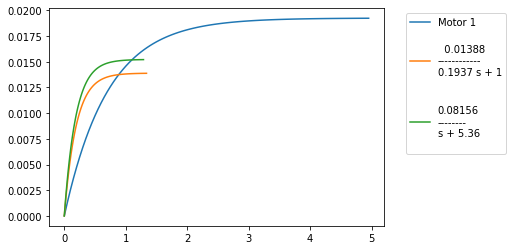

In [ ]:
#Comparação motor 1
fig, ax = plt.subplots()

x1,y1 = tf1_m1.tf.step()
ax.plot(x1,y1, label='Motor 1') #plotar as coordenadas x e y e nomear esse conjunto de dados como 'Motor 1'



y1_2,x1_2 = step(tf1_m2.tf)
ax.plot(x1_2,y1_2, label=str(tf1_m2.tf))


y1_3,x1_3 = step(tf1_ml)
ax.plot(x1_3,y1_3, label=(str(tf1_ml)))


ax.legend()
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left' )
plt.show()

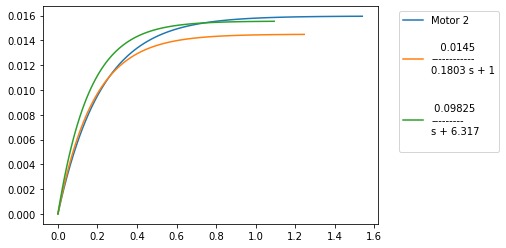

In [ ]:
#Comparação motor 2
fig, ax = plt.subplots()

x2_1,y2_1 = tf2_m1.tf.step()
ax.plot(x2_1,y2_1, label='Motor 2')

y2_2,x2_2 = step(tf2_m2.tf)
ax.plot(x2_2,y2_2, label=str(tf2_m2.tf))

y2_3,x2_3 = step(tf2_ml)
ax.plot(x2_3,y2_3, label=str(tf2_ml))

ax.legend()
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left' )
plt.show()

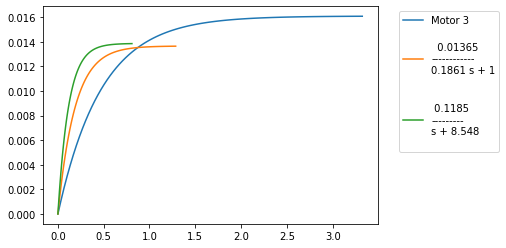

In [ ]:
#Comparação motor 3

fig, ax = plt.subplots()

x3_1,y3_1 = tf3_m1.tf.step()
ax.plot(x3_1,y3_1, label='Motor 3')

y3_2,x3_2 = step(tf3_m2.tf)
ax.plot(x3_2,y3_2, label=str(tf3_m2.tf))

y3_3,x3_3 = step(tf3_ml)
ax.plot(x3_3,y3_3, label=str(tf3_ml))

ax.legend()
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left' )
plt.show()

https://jckantor.github.io/CBE30338/05.04-Controller-Tuning-Rules-in-Frequency-Domain.html

##Projeto do controlador de velocidade PI

bla bla bla, oq é um controlador, pq escolher um PI

###Definição dos Parâmetros

In [ ]:
G1 = tf1_m2.tf
G2 = tf2_m2.tf
G3 = tf3_m2.tf

####Máximo de sobressinal 

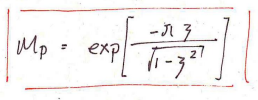

Mp = 1%

In [ ]:
Mp = 1/100
zeta = np.sqrt((np.log(Mp)**2)/(np.pi**2 + np.log(Mp)**2))
zeta


0.8260850546139571

####Tempo de assentamento

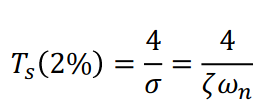

Ts = 0.5

In [ ]:
Ts = 0.5
omega_n = 4/(zeta*Ts)
omega_n

9.684232822416245

####Definição dos polos desejados

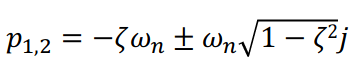

In [ ]:
p1 = -zeta*omega_n + (omega_n*np.sqrt(1-zeta**2))*1j
p2 = -zeta*omega_n - (omega_n*np.sqrt(1-zeta**2))*1j

###Controlador PI

Utilizando o PI 



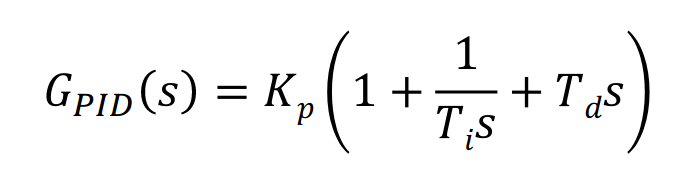

In [ ]:
Td = 0
Kp = sympy.symbols('Kp')
Ti = sympy.symbols('Ti')
s = sympy.symbols('s')
G_PID = Kp*(1+1/(Ti*s)+Td*s)
G_PID


Kp*(1 + 1/(Ti*s))

Arrumando a Função

In [ ]:
G_PID = Kp*((Ti*s+1)/(Ti*s))
G_PID

Kp*(Ti*s + 1)/(Ti*s)

####Critério de *Fase*

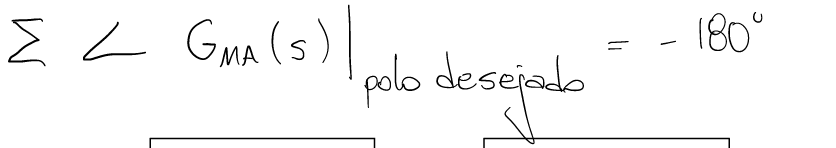

In [ ]:
#Determinação da constante de Tempo de integração (Ti) de cada motor
aux = np.tan(-np.pi + np.angle(G1.den[0][0][0]*p1+1) + np.angle(p1))
Ti_1 = aux/(p1.imag-p1.real*aux)
print(Ti_1)

aux = np.tan(-np.pi + np.angle(G2.den[0][0][0]*p1+1) + np.angle(p1))
Ti_2 = aux/(p1.imag-p1.real*aux)
print(Ti_2)

aux = np.tan(-np.pi + np.angle(G3.den[0][0][0]*p1+1) + np.angle(p1))
Ti_3 = aux/(p1.imag-p1.real*aux)
print(Ti_3)

0.11554991262083175
0.11147188405327257
0.11332092945117932


####Critério do *Módulo*

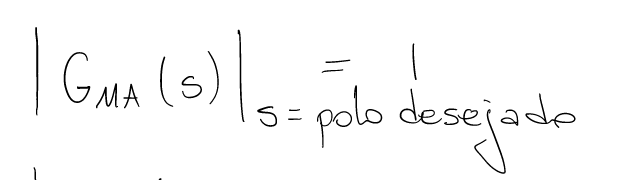

In [ ]:
#Determinação da constante de proporcionalidade (Kp) de cada motor
Kp_1 = (np.absolute(Ti_1*p1)*np.absolute(G1.den[0][0][0]*p1+1))/(np.absolute(Ti_1*p1+1)*G1.num[0][0][0])
print(Kp_1)

Kp_2 = (np.absolute(Ti_2*p1)*np.absolute(G2.den[0][0][0]*p1+1))/(np.absolute(Ti_2*p1+1)*G2.num[0][0][0])
print(Kp_2)

Kp_3 = (np.absolute(Ti_3*p1)*np.absolute(G3.den[0][0][0]*p1+1))/(np.absolute(Ti_3*p1+1)*G3.num[0][0][0])
print(Kp_3)

151.16556418369055
130.04988348227812
144.89267700413836


In [ ]:
#Determinação da função de transferência do controlador de cada motor
G1_PID = Kp_1*tf([Ti_1,1],[Ti_1,0])
print(G1_PID)

G2_PID = Kp_2*tf([Ti_2,1],[Ti_2,0])
print(G2_PID)

G3_PID = Kp_3*tf([Ti_3,1],[Ti_3,0])
print(G3_PID)


17.47 s + 151.2
---------------
   0.1155 s


14.5 s + 130
------------
  0.1115 s


16.42 s + 144.9
---------------
   0.1133 s



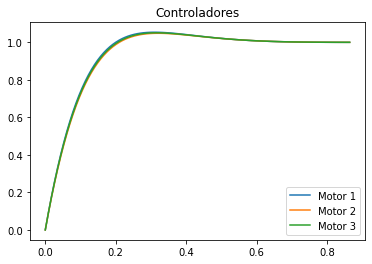

In [ ]:
#Adquirindo as coordenadas x e y para plotar o gráfico dos controladores
yc_1,xc_1 = step(feedback(G1_PID*G1,))
plt.plot(xc_1,yc_1, label='Motor 1')

yc_2,xc_2 = step(feedback(G2_PID*G2,))
plt.plot(xc_2,yc_2, label='Motor 2')

yc_3,xc_3 = step(feedback(G3_PID*G3,))
plt.plot(xc_3,yc_3, label='Motor 3')

plt.title("Controladores")
plt.legend()
plt.show()

##Implementação Controlador


###Equação de diferenças

In [ ]:
#Para aplicar o controlador em um microcontrolador
G1_PID_z = G1_PID.sample(0.25)
print(G1_PID_z)

G2_PID_z = G2_PID.sample(0.25)
print(G2_PID_z) 

G3_PID_z = G3_PID.sample(0.25)
print(G3_PID_z) 


151.2 z + 175.9
---------------
     z - 1

dt = 0.25


130 z + 161.6
-------------
    z - 1

dt = 0.25


144.9 z + 174.8
---------------
     z - 1

dt = 0.25

